In [32]:
#load the modules
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn import model_selection   
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import neighbors
from sklearn import svm
from sklearn import ensemble
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

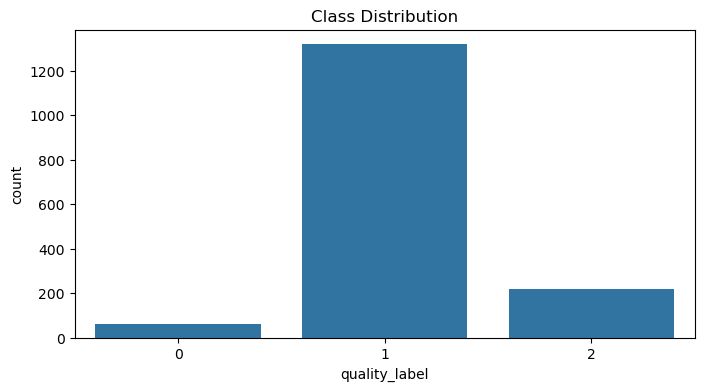

In [33]:
#read the file and show the data
wine = pd.read_csv("winequality-red.csv")
#wine.info()

#create a new column to divide the good wine and the bad wine
#quality of wine equal or greater than 7 is good, we label the good wine as 1, else will be 0
wine["quality_label"] = wine["quality"].apply(lambda x: 0 if x < 5 else (1 if 5<= x < 7 else 2))

#plot a bar to see the number of good wine and bad wine
plt.figure(figsize=(8,4))
sns.countplot(x='quality_label', data = wine)
plt.title('Class Distribution')
plt.show()
#we can clearly see the number of low-quality wines far exceeds the number of high-quality wines



quality_label
1    1055
2     174
0      50
Name: count, dtype: int64
quality_label
1    1055
2    1055
0    1055
Name: count, dtype: int64


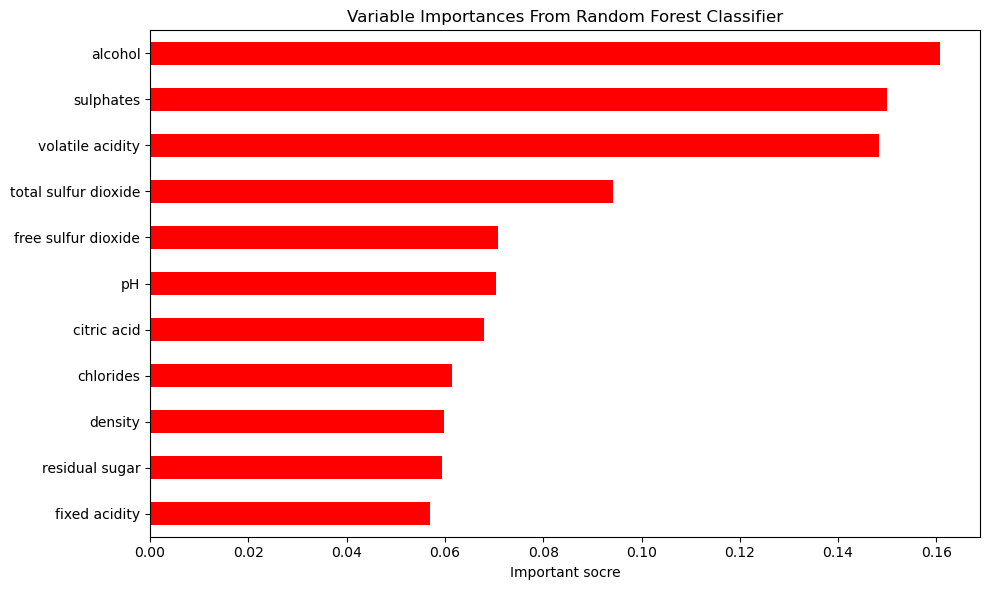

In [39]:
#Define X and y
X = wine.drop(['quality','quality_label'], axis =1)
y = wine['quality_label']
#defining y as quality labels instead of quality to set this problem as a classification target
#The specific task in the code is binary classification (good/bad wine)
#but we still can go back to regression analysis to find the specific scores of quality of wine after this by defining new y

#Separate the data to train data and the test data, and the train set is 75% of the data.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,
                                                                    train_size = 0.8, 
                                                                    stratify=y,
                                                                    random_state=42)

#The data is imbalanced, so I am going to use SMOTE to help me balance the dataset without simply duplicating samples.
smote = SMOTE(random_state = 42)
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)
print(y_train.value_counts())

# Train a Random Forest model
rf_model = ensemble.RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state = 42)
rf_model.fit(X_train_resample, y_train_resample)
print(y_train_resample.value_counts()) #check the size of y_train_resample to see if the data is balanced

#Get variable importances
impor = pd.Series(rf_model.feature_importances_, index = X.columns)

#Sort and plot the variable importances
plt.figure(figsize=(10,6))
impor.sort_values().plot(kind="barh", color = "red")
plt.title("Variable Importances From Random Forest Classifier")
plt.xlabel("Important socre")
plt.tight_layout()
plt.show()
#We can clearly see that 'alcohol' is the most significant variable that influences the quality of wine. 

In [40]:
#check the accuracy of RandomForest Classifier model
y_pred = rf_model.predict(X_test)
rf_accuracy = metrics.accuracy_score(y_test,y_pred)
print("Random Forest Accuracy",rf_accuracy)
#Check the accuracy of other models
#DecisionTree
de_model = tree.DecisionTreeClassifier(random_state=42)
de_model.fit(X_train,y_train)
de_pred = de_model.predict(X_test)
de_accuracy = metrics.accuracy_score(y_test,de_pred)
print("Decision Tree Accuracy",de_accuracy)
#SVM
svm_model = svm.SVC(gamma="auto")
svm_model.fit(X_train,y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = metrics.accuracy_score(y_test, svm_pred)
print("SVM Accuracy",svm_accuracy)
#After comparing the accuracy of these 3 models, Random Forest Classification will be better to use to predict.


Random Forest Accuracy 0.834375
Decision Tree Accuracy 0.821875
SVM Accuracy 0.834375


              precision    recall  f1-score   support

           0       0.33      0.38      0.36        13
           1       0.94      0.86      0.90       264
           2       0.56      0.84      0.67        43

    accuracy                           0.83       320
   macro avg       0.61      0.69      0.64       320
weighted avg       0.86      0.83      0.84       320



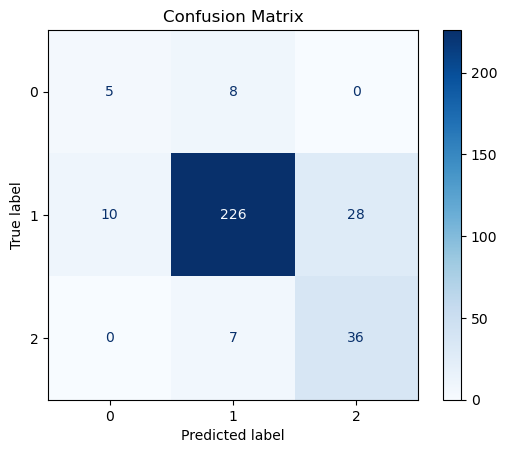

In [41]:
# Get optimal threshold using precision-recall curve 
#y_proba = rf_model.predict_proba(X_test)[:, 1]
#precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba)
#f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
#best_threshold = thresholds[np.argmax(f1_scores)]
# Apply optimal threshold
#y_pred_optimized = (y_proba >= best_threshold).astype(int)
#print("\nOptimized Classification Report:")
print(metrics.classification_report(y_test, y_pred))

#Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



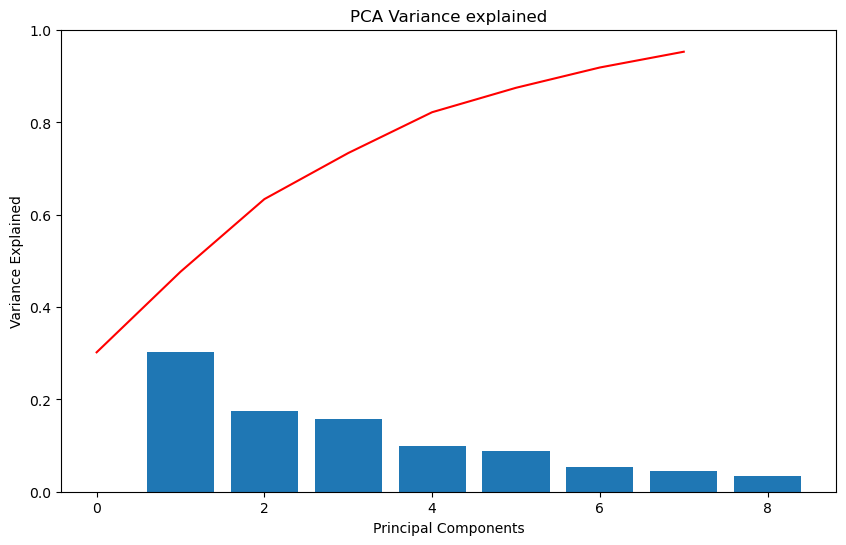

Original features: 11
Reduced components: 8
Variance retained: 95.32%


In [42]:
#PCA(Principal Component Analysis)
#Since quality of wine has been influenced by 11 variables, that may some variables are useless for quality of wine.
#So we can use PCA method to reduce the dimension of variables and may be helpful. 
#Split the data first
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)
#balance the data
smote = SMOTE(random_state = 42)
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

#Standardize variables, it is important in PCA, which is to compute mean and sd for different variable columns
#and make each element in that column subtract mean, and divide by sd. 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resample) 
X_test_scaled = scaler.transform(X_test)

#Apply PCA
pca = PCA(n_components=0.95) #keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#Visualize explained variance
plt.figure(figsize=(10,6))
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'r-')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('PCA Variance explained')
plt.show()

print(f"Original features: {X.shape[1]}")
print(f"Reduced components: {X_train_pca.shape[1]}")
print(f"Variance retained: {np.sum(pca.explained_variance_ratio_):.2%}")
#We have reduced 11 variables to 8 variables

In [43]:
# Train Random Forest on PCA components
rf_pca = ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_train_pca, y_train_resample)

#Evaluate the accuracy and AUC after PCA
rf_pca.fit(X_train_pca, y_train_resample)
y_pred_pca = rf_pca.predict(X_test_pca)
print("\nPCA feature model:")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_pca))
print(metrics.classification_report(y_test, y_pred_pca))

# Compared with original model
#rf_model.fit(X_train_scaled, y_train_resample)
#y_prob= rf_model.predict_proba(X_test_scaled)[:,1]
#precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_prob)
#f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
#best_threshold = thresholds[np.argmax(f1_scores)]
#y_pred_optimized = (y_prob >= best_threshold).astype(int)
print("\nOriginal feature model:")
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
#We can see the PCA accuracy and AUC value is little bit smaller than original one
#PCA is not best for this project, but its computing efficiency, noise resistance
# and data compatibility are great, just not the best for this one. 



PCA feature model:
Accuracy: 0.81875
              precision    recall  f1-score   support

           0       0.30      0.46      0.36        13
           1       0.93      0.84      0.88       264
           2       0.55      0.77      0.64        43

    accuracy                           0.82       320
   macro avg       0.59      0.69      0.63       320
weighted avg       0.85      0.82      0.83       320


Original feature model:
Accuracy: 0.834375
              precision    recall  f1-score   support

           0       0.33      0.38      0.36        13
           1       0.94      0.86      0.90       264
           2       0.56      0.84      0.67        43

    accuracy                           0.83       320
   macro avg       0.61      0.69      0.64       320
weighted avg       0.86      0.83      0.84       320

